In [25]:
%load_ext autoreload
%autoreload 2

In [20]:
import os
import sys

import numpy as np
from scipy.optimize import fsolve
from scipy.stats import poisson, skellam
import matplotlib.pyplot as plt
plt.style.use('ggplot')

sys.path.append('/Users/i.tolkachev/freelance/git/softpro/')

import odds

In [16]:
# input params
half_total_value, to, tu, half_hdp_value, hdp1, hdp2 = 2.5, 1.847, 2.03, 0.5, 1.8, 2.1
home, away, draw = 3.64, 2.1, 3.51

In [17]:
# margin from calculator
def fair_odd(odd, margin):
    return (odd*(margin+1))

def margin_2(odd_1, odd_2):
    return 1/odd_1 + 1/odd_2 - 1

def margin_3(odd_1, odd_2, odd_3):
    return 1/odd_1 + 1/odd_2 + 1/odd_3 - 1

In [26]:
# test system solver for skellam
k1 = half_total_value
goals = int(k1)
k2 = half_hdp_value

m = margin_2(to, tu)
fair_tu = fair_odd(tu, m)
m = margin_3(home, draw, away)
fair_draw = fair_odd(draw, m)

# prob less than k1 goals
p_under = odds.odd_to_prob(fair_tu)

# get mu = mu1 + mu2 before game ending
mu = odds.get_poisson_mu(goals, p_under)
print('mu from poisson optimizer: ', mu)

# prob less than total goals
p = sum(poisson.pmf(g, mu) for g in range(0, goals+1))
print('prob less than total goals:', p)
print('prob less than total goals from odds:', p_under)

hdp_val = int(k2*(-1) + 1) if k2 < 0 else int(k2*(-1))
p_hdp = odds.odd_to_prob(hdp1)
mu1, mu2 = odds.get_skellam_mu(hdp_val, p_hdp, mu)
print('skellam mu1: ', mu1, 'skellam mu2: ', mu2)
p_draw = odds.odd_to_prob(fair_draw)
print('draw proba from odds: ', p_draw)
sk_opt = odds.SkellamOptimizer(k=hdp_val, a=p_hdp, mu=mu)

#solve system

def equations(p):
    mu1, mu2 = p
    return (abs(p_hdp - sum(skellam.pmf(k, mu1, mu2) for k in range(hdp_val, 20))),
            skellam.pmf(0, mu1, mu2) - p_draw)

x, y =  fsolve(equations, (mu/2, mu/2))

print(equations((x, y)))

mu from poisson optimizer:  2.770996093750002
prob less than total goals: 0.47639597854365945
prob less than total goals from odds: 0.47639927779210733
skellam mu1:  1.2314648437499969 skellam mu2:  1.5395312500000053
draw proba from odds:  0.275049115913556
(5.773159728050814e-14, -8.448797217397441e-14)


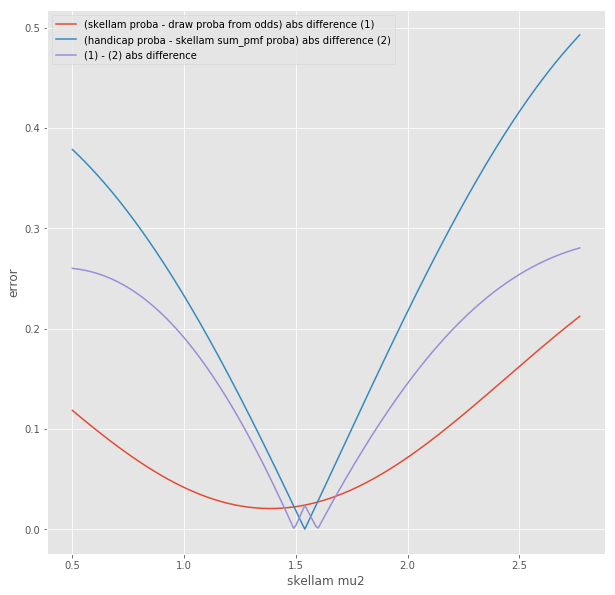

In [27]:
plt.figure(figsize=(10, 10))
x = np.arange(0.5, 6, 0.01)

y = [abs(skellam.pmf(0, mu - c, c) - p_draw) for c in x]
plt.plot(x, y, label='(skellam proba - draw proba from odds) abs difference (1)')

y = [abs(p_hdp - sum(skellam.pmf(k, mu - c, c) for k in range(hdp_val, 20))) for c in x]
plt.plot(x, y, label='(handicap proba - skellam sum_pmf proba) abs difference (2)')

y = [abs(abs(skellam.pmf(0, mu - c, c) - p_draw) - 
      abs(p_hdp - sum(skellam.pmf(k, mu - c, c) for k in range(hdp_val, 20)))) for c in x]
plt.plot(x, y, label='(1) - (2) abs difference')

plt.legend()
plt.xlabel('skellam mu2')
plt.ylabel('error')
plt.show()

## Выводы

- По красной линии становится понятно, что чистая вероятность ничьи не согласуется с вероятностями исходов, которые подаются на вход модели, а значит на MoneyLine будет как правило большая ошибка
- По фиолетовой линии видно, что учёт ничьи не исправляет ошибку значительным образом